<a href="https://colab.research.google.com/github/slegro97/dutch-fashion/blob/main/UnderstandingSalesDrivers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/PythonProjects/Statistics with Python/Regression Analysis/Capstone Project_ Sales Drivers

/content/drive/MyDrive/PythonProjects/Statistics with Python/Regression Analysis/Capstone Project_ Sales Drivers


# Functions

In [ ]:
def interpret_regression(model):
    """
    Automatically interprets a regression model from statsmodels, differentiating between binary and continuous variables.

    Parameters:
    model: statsmodels regression results (fitted model)

    Returns:
    None - prints out interpretation of coefficients (eXcluding the intercept)
    """

    # Get the model coefficients, p-values, and exogenous data (independent variables)
    params = model.params
    pvalues = model.pvalues
    exog_data = model.model.exog
    exog_names = model.model.exog_names

    # Get the design matriX as a DataFrame for easier processing
    exog_df = pd.DataFrame(exog_data, columns=exog_names)

    for var in exog_names:
        # Skip the intercept (usually named 'const')
        if var == 'const':
            continue

        coef = params[var]
        pval = pvalues[var]

        # Determine if the variable is binary (has only two unique values)
        unique_values = exog_df[var].unique()
        if len(unique_values) == 2 and set(unique_values).issubset({0, 1}):
            var_type = 'binary'
        else:
            var_type = 'continuous'

        # Check significance level
        significance = "statistically significant" if pval < 0.05 else "not statistically significant"

        # Generate interpretation based on variable type
        if var_type == 'binary':
            if coef > 0:
                interpretation = (f"For the binary variable '{var}', having this variable (coded as 1) "
                                  f"increases the outcome by {coef:.4f} units, and it is {significance}.")
            else:
                interpretation = (f"For the binary variable '{var}', having this variable (coded as 1) "
                                  f"decreases the outcome by {abs(coef):.4f} units, and it is {significance}.")

        elif var_type == 'continuous':
            interpretation = (f"For the continuous variable '{var}', a one-unit increase leads to a change "
                              f"of {coef:.4f} units in the outcome, and it is {significance}.")

        # Print interpretation with a separator line
        print(interpretation)
        print("-" * 50)

# Libraries and Data

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# Data
raw_data = pd.read_csv('Clothing.csv')
raw_data.head(10)

,tsales,sales,margin,nown,nfull,npart,naux,hoursw,hourspw,inv1,inv2,ssize,start
0,750000,4411.765,41.0,1.0000,1.0000,1.0000,1.5357,76,16.75596,17166.67,27177.04,170,41.0
1,1926395,4280.878,39.0,2.0000,2.0000,3.0000,1.5357,192,22.49376,17166.67,27177.04,450,39.0
2,1250000,4166.667,40.0,1.0000,2.0000,2.2222,1.4091,114,17.19120,292857.20,71570.55,300,40.0
3,694227,2670.104,40.0,1.0000,1.0000,1.2833,1.3673,100,21.50260,22207.04,15000.00,260,40.0
4,750000,15000.000,44.0,2.0000,1.9556,1.2833,1.3673,104,15.74279,22207.04,10000.00,50,44.0
5,400000,4444.444,41.0,2.0000,1.9556,1.2833,1.3673,72,10.89885,22207.04,22859.85,90,41.0
6,1300000,3250.000,39.0,1.2228,1.0000,3.0000,4.0000,161,17.45674,22207.04,22859.85,400,39.0
7,495340,4953.400,28.0,2.0000,1.9556,1.2833,1.3673,80,12.10984,22207.04,22859.85,100,28.0
8,1200000,2666.667,41.0,1.0000,3.0000,2.2222,1.4091,158,20.70420,292857.20,5000.00,450,41.0
9,495340,6604.533,37.0,1.0000,1.9556,1.2833,1.0000,87,16.60654,22207.04,22859.85,75,37.0


# Data Preparation and Cleaning

<Axes: >

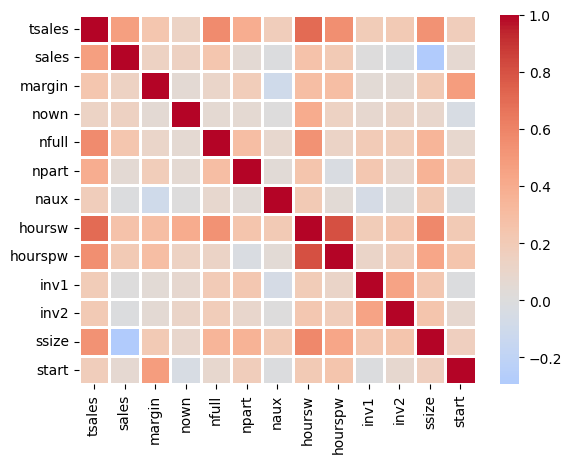

In [ ]:
# Correlation matrix to determine variables of interest
sns.heatmap(raw_data.corr(),
            cmap = 'coolwarm',
            center = 0,
            linewidths = 1,
            linecolor = 'white')

**Top factors affecting total sales (tsales)**:

- Number of full time workers (nfull)
- Total number of hours worked (hoursw)
- Store size in meters sq. (ssize)

**Other notable interactions**:

- Margin and start date correlation

In [ ]:
# Remove unneccesary data/columns
df = raw_data[['tsales', 'nfull', 'hoursw', 'ssize']]

In [ ]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tsales  400 non-null    int64  
 1   nfull   400 non-null    float64
 2   hoursw  400 non-null    int64  
 3   ssize   400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


# Exploratory Data Analysis

In [ ]:
# Summary Statistics
df.describe()

,tsales,nfull,hoursw,ssize
count,4.000000e+02,400.000000,400.000000,400.000000
mean,8.335842e+05,2.069384,121.137500,151.050000
std,5.834638e+05,1.015598,64.435343,112.498254
min,5.000000e+04,1.000000,32.000000,16.000000
25%,4.953400e+05,1.923100,80.000000,80.000000
50%,6.942270e+05,1.955600,104.000000,120.000000
75%,9.768170e+05,2.066400,145.250000,190.000000
max,5.000000e+06,8.000000,582.000000,1214.000000


<Axes: >

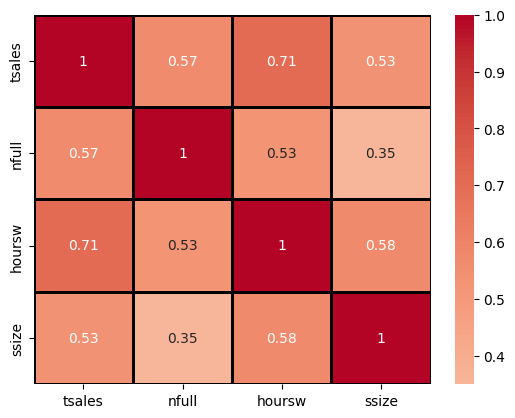

In [ ]:
# Correlation matrix
sns.heatmap(df.corr(),
            annot = True,
            cmap = 'coolwarm',
            center = 0,
            linewidths = 1,
            linecolor = 'black')

# Perform Multilinear regression with key factors for total sales (tsales)

In [ ]:
# Isolate X and y
y = df['tsales']
X = df.drop(columns=['tsales'])

# Add a constant to X
X = sm.add_constant(X)

# Set training and test sets
X_train, X_test, y_train, y_test = tts(X, y,
                                       test_size = 0.2,
                                       random_state = 1502)

# Build regression model
model = sm.OLS(y_train, X_train).fit()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tsales   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     127.5
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           4.03e-54
Time:                        22:12:47   Log-Likelihood:                -4567.9
No. Observations:                 320   AIC:                             9144.
Df Residuals:                     316   BIC:                             9159.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.004e+05   5.81e+04     -3.449      0.001   -3.15e+05   -8.61e+04
nfull       1.602e+05   2.55e+04      6.290      0.000     1.1e+05     2.1e+05
hoursw      4778.5919    525.771      9.089      0.000    3744.138    5813.046
ssize        975.5511    277.277      3.518      0.000     430.009    1521.093
==============================================================================
Omnibus:                      198.667   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3211.597
Skew:                           2.230   Prob(JB):                         0.00
Kurtosis:                      17.865   Cond. No.                         596.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# apply the function
interpret_regression(model)

For the continuous variable 'nfull', a one-unit increase leads to a change of 160213.4674 units in the outcome, and it is statistically significant.
--------------------------------------------------
For the continuous variable 'hoursw', a one-unit increase leads to a change of 4778.5919 units in the outcome, and it is statistically significant.
--------------------------------------------------
For the continuous variable 'ssize', a one-unit increase leads to a change of 975.5511 units in the outcome, and it is statistically significant.
--------------------------------------------------


# Assess regression model for total sales (tsales)

In [ ]:
# Predict with the regression model
predictions = model.predict(X_test)

# Measure the accuracy with MAE and RMSE
print(f'The MAE is: {mean_absolute_error(y_test, predictions):.0f}')
print(f'The RMSE is: {mean_squared_error(y_test, predictions, squared = False):.0f}')

The MAE is: 277797
The RMSE is: 392641
